In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from src.preprocess import preprocess_folder
from src.format_data import create_dataset
from src.model import create_embedding_model, create_flux_model
from src.losses import get_companion_std, keep_back

from tensorflow.keras.optimizers import Adam
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

2023-06-09 16:15:03.453912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 16:15:03.652369: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

In [2]:
cube, psf, rot_angles, table = preprocess_folder(root='./data/fake', 
												 target_folder='./data/fake/preprocessed')

table = table[table['snr'] > 1]

window_size = 30
dataset = create_dataset(cube, psf, rot_angles, table, window_size=window_size,
                         batch_size=2000, repeat=2)

model = create_flux_model(window_size=window_size)

optimizer = Adam(1e-5)
model.compile(loss_fn=keep_back, optimizer=optimizer)

es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-4,
        patience=50,
        mode='min',
        restore_best_weights=True,
    )

2023-06-09 16:15:06.693079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[INFO] Restoring saved values


2023-06-09 16:15:07.235529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22316 MB memory:  -> device: 0, name: A30, pci bus id: 0000:21:00.0, compute capability: 8.0


In [3]:
# model.summary()
table = table[table['snr'] >2]
table

,x,y,flux,fwhm_mean,snr
0,386.000008,727.508451,137.768770,4.946172,80.595763
1,517.649572,505.890252,42.758980,3.905442,2.443127
4,509.704804,523.014917,27.589107,5.138378,2.024620


In [4]:
%%time
hist = model.fit(dataset, epochs=10000, callbacks=[es])

Epoch 1/10000


2023-06-09 16:15:12.368707: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-06-09 16:15:14.251555: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 4s 4s/step - loss: 13.6697
Epoch 2/10000
1/1 [==============================] - 0s 33ms/step - loss: 13.6685
Epoch 3/10000
1/1 [==============================] - 0s 30ms/step - loss: 13.6673
Epoch 4/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6660
Epoch 5/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6648
Epoch 6/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6635
Epoch 7/10000
1/1 [==============================] - 0s 30ms/step - loss: 13.6623
Epoch 8/10000
1/1 [==============================] - 0s 30ms/step - loss: 13.6611
Epoch 9/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6598
Epoch 10/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6586
Epoch 11/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.6573
Epoch 12/10000
1/1 [==============================] - 0s 32ms/step - loss: 13.6561
Epoch 13/10000
1/1 [=========

1/1 [==============================] - 0s 34ms/step - loss: 13.5215
Epoch 101/10000
1/1 [==============================] - 0s 35ms/step - loss: 13.5195
Epoch 102/10000
1/1 [==============================] - 0s 32ms/step - loss: 13.5175
Epoch 103/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.5155
Epoch 104/10000
1/1 [==============================] - 0s 35ms/step - loss: 13.5134
Epoch 105/10000
1/1 [==============================] - 0s 36ms/step - loss: 13.5114
Epoch 106/10000
1/1 [==============================] - 0s 36ms/step - loss: 13.5093
Epoch 107/10000
1/1 [==============================] - 0s 35ms/step - loss: 13.5073
Epoch 108/10000
1/1 [==============================] - 0s 36ms/step - loss: 13.5052
Epoch 109/10000
1/1 [==============================] - 0s 41ms/step - loss: 13.5031
Epoch 110/10000
1/1 [==============================] - 0s 33ms/step - loss: 13.5011
Epoch 111/10000
1/1 [==============================] - 0s 32ms/step - loss: 13.4990
Epoch 11

1/1 [==============================] - 0s 31ms/step - loss: 13.2831
Epoch 198/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2803
Epoch 199/10000
1/1 [==============================] - 0s 32ms/step - loss: 13.2774
Epoch 200/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2745
Epoch 201/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2716
Epoch 202/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2687
Epoch 203/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2658
Epoch 204/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2629
Epoch 205/10000
1/1 [==============================] - 0s 33ms/step - loss: 13.2600
Epoch 206/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2571
Epoch 207/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2541
Epoch 208/10000
1/1 [==============================] - 0s 31ms/step - loss: 13.2512
Epoch 20

1/1 [==============================] - 0s 32ms/step - loss: 12.9710
Epoch 295/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.9674
Epoch 296/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.9638
Epoch 297/10000
1/1 [==============================] - 0s 30ms/step - loss: 12.9602
Epoch 298/10000
1/1 [==============================] - 0s 30ms/step - loss: 12.9566
Epoch 299/10000
1/1 [==============================] - 0s 30ms/step - loss: 12.9530
Epoch 300/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.9493
Epoch 301/10000
1/1 [==============================] - 0s 30ms/step - loss: 12.9457
Epoch 302/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.9421
Epoch 303/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.9384
Epoch 304/10000
1/1 [==============================] - 0s 33ms/step - loss: 12.9348
Epoch 305/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.9311
Epoch 30

1/1 [==============================] - 0s 30ms/step - loss: 12.5834
Epoch 392/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.5789
Epoch 393/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5744
Epoch 394/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5699
Epoch 395/10000
1/1 [==============================] - 0s 30ms/step - loss: 12.5654
Epoch 396/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5609
Epoch 397/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.5563
Epoch 398/10000
1/1 [==============================] - 0s 33ms/step - loss: 12.5518
Epoch 399/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5472
Epoch 400/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.5426
Epoch 401/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5380
Epoch 402/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.5334
Epoch 40

1/1 [==============================] - 0s 31ms/step - loss: 12.0795
Epoch 489/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0735
Epoch 490/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0677
Epoch 491/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0618
Epoch 492/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0559
Epoch 493/10000
1/1 [==============================] - 0s 32ms/step - loss: 12.0500
Epoch 494/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0441
Epoch 495/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0382
Epoch 496/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0323
Epoch 497/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0265
Epoch 498/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0206
Epoch 499/10000
1/1 [==============================] - 0s 31ms/step - loss: 12.0147
Epoch 50

1/1 [==============================] - 0s 32ms/step - loss: 11.5341
Epoch 586/10000
1/1 [==============================] - 0s 33ms/step - loss: 11.5289
Epoch 587/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.5236
Epoch 588/10000
1/1 [==============================] - 0s 30ms/step - loss: 11.5183
Epoch 589/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.5130
Epoch 590/10000
1/1 [==============================] - 0s 30ms/step - loss: 11.5077
Epoch 591/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.5025
Epoch 592/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.4972
Epoch 593/10000
1/1 [==============================] - 0s 32ms/step - loss: 11.4919
Epoch 594/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.4868
Epoch 595/10000
1/1 [==============================] - 0s 30ms/step - loss: 11.4815
Epoch 596/10000
1/1 [==============================] - 0s 33ms/step - loss: 11.4763
Epoch 59

1/1 [==============================] - 0s 30ms/step - loss: 11.0548
Epoch 683/10000
1/1 [==============================] - 0s 32ms/step - loss: 11.0502
Epoch 684/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0457
Epoch 685/10000
1/1 [==============================] - 0s 32ms/step - loss: 11.0412
Epoch 686/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0366
Epoch 687/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0321
Epoch 688/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0276
Epoch 689/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0231
Epoch 690/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0186
Epoch 691/10000
1/1 [==============================] - 0s 31ms/step - loss: 11.0142
Epoch 692/10000
1/1 [==============================] - 0s 32ms/step - loss: 11.0097
Epoch 693/10000
1/1 [==============================] - 0s 32ms/step - loss: 11.0052
Epoch 69

1/1 [==============================] - 0s 29ms/step - loss: 10.6559
Epoch 780/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.6523
Epoch 781/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6487
Epoch 782/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.6450
Epoch 783/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6415
Epoch 784/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6378
Epoch 785/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6343
Epoch 786/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.6307
Epoch 787/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6271
Epoch 788/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6235
Epoch 789/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.6200
Epoch 790/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.6165
Epoch 79

1/1 [==============================] - 0s 31ms/step - loss: 10.3512
Epoch 877/10000
1/1 [==============================] - 0s 32ms/step - loss: 10.3485
Epoch 878/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3459
Epoch 879/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.3433
Epoch 880/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3407
Epoch 881/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.3381
Epoch 882/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3355
Epoch 883/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3330
Epoch 884/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3304
Epoch 885/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3278
Epoch 886/10000
1/1 [==============================] - 0s 32ms/step - loss: 10.3253
Epoch 887/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.3227
Epoch 88

1/1 [==============================] - 0s 31ms/step - loss: 10.1396
Epoch 974/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1379
Epoch 975/10000
1/1 [==============================] - 0s 32ms/step - loss: 10.1362
Epoch 976/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1344
Epoch 977/10000
1/1 [==============================] - 0s 30ms/step - loss: 10.1326
Epoch 978/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1309
Epoch 979/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1291
Epoch 980/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1274
Epoch 981/10000
1/1 [==============================] - 0s 33ms/step - loss: 10.1257
Epoch 982/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1240
Epoch 983/10000
1/1 [==============================] - 0s 31ms/step - loss: 10.1223
Epoch 984/10000
1/1 [==============================] - 0s 36ms/step - loss: 10.1206
Epoch 98

Epoch 1070/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9942
Epoch 1071/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9929
Epoch 1072/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9915
Epoch 1073/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9901
Epoch 1074/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9887
Epoch 1075/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.9873
Epoch 1076/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9859
Epoch 1077/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9846
Epoch 1078/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.9831
Epoch 1079/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9818
Epoch 1080/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.9803
Epoch 1081/10000
1/1 [==============================] - 0s 31ms/step - loss:

1/1 [==============================] - 0s 31ms/step - loss: 9.7979
Epoch 1168/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.7956
Epoch 1169/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.7934
Epoch 1170/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.7911
Epoch 1171/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.7889
Epoch 1172/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.7866
Epoch 1173/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.7844
Epoch 1174/10000
1/1 [==============================] - 0s 29ms/step - loss: 9.7822
Epoch 1175/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.7800
Epoch 1176/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.7778
Epoch 1177/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.7756
Epoch 1178/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.7734
Epoch 117

1/1 [==============================] - 0s 30ms/step - loss: 9.6118
Epoch 1265/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.6102
Epoch 1266/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.6086
Epoch 1267/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.6070
Epoch 1268/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.6054
Epoch 1269/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.6038
Epoch 1270/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.6022
Epoch 1271/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.6006
Epoch 1272/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.5990
Epoch 1273/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.5974
Epoch 1274/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.5958
Epoch 1275/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.5942
Epoch 127

1/1 [==============================] - 0s 31ms/step - loss: 9.4734
Epoch 1362/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4721
Epoch 1363/10000
1/1 [==============================] - 0s 33ms/step - loss: 9.4708
Epoch 1364/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4696
Epoch 1365/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4683
Epoch 1366/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4670
Epoch 1367/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.4658
Epoch 1368/10000
1/1 [==============================] - 0s 33ms/step - loss: 9.4645
Epoch 1369/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4633
Epoch 1370/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4620
Epoch 1371/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4607
Epoch 1372/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.4595
Epoch 137

1/1 [==============================] - 0s 31ms/step - loss: 9.3583
Epoch 1459/10000
1/1 [==============================] - 0s 33ms/step - loss: 9.3571
Epoch 1460/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.3561
Epoch 1461/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.3549
Epoch 1462/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.3539
Epoch 1463/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.3528
Epoch 1464/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.3517
Epoch 1465/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.3506
Epoch 1466/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.3495
Epoch 1467/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.3484
Epoch 1468/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.3473
Epoch 1469/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.3463
Epoch 147

1/1 [==============================] - 0s 32ms/step - loss: 9.2590
Epoch 1556/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.2581
Epoch 1557/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2571
Epoch 1558/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.2562
Epoch 1559/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2552
Epoch 1560/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2543
Epoch 1561/10000
1/1 [==============================] - 0s 33ms/step - loss: 9.2533
Epoch 1562/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2523
Epoch 1563/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.2514
Epoch 1564/10000
1/1 [==============================] - 0s 33ms/step - loss: 9.2505
Epoch 1565/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2495
Epoch 1566/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.2486
Epoch 156

1/1 [==============================] - 0s 29ms/step - loss: 9.1720
Epoch 1653/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1712
Epoch 1654/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1704
Epoch 1655/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1696
Epoch 1656/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1687
Epoch 1657/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1679
Epoch 1658/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.1670
Epoch 1659/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.1662
Epoch 1660/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.1654
Epoch 1661/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.1645
Epoch 1662/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.1637
Epoch 1663/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.1628
Epoch 166

1/1 [==============================] - 0s 31ms/step - loss: 9.0949
Epoch 1750/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0941
Epoch 1751/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0934
Epoch 1752/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0927
Epoch 1753/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0919
Epoch 1754/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0911
Epoch 1755/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0904
Epoch 1756/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0897
Epoch 1757/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.0890
Epoch 1758/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0883
Epoch 1759/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.0876
Epoch 1760/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0868
Epoch 176

1/1 [==============================] - 0s 32ms/step - loss: 9.0255
Epoch 1847/10000
1/1 [==============================] - 0s 30ms/step - loss: 9.0249
Epoch 1848/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0242
Epoch 1849/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0235
Epoch 1850/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0228
Epoch 1851/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.0222
Epoch 1852/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0214
Epoch 1853/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0208
Epoch 1854/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0202
Epoch 1855/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0195
Epoch 1856/10000
1/1 [==============================] - 0s 32ms/step - loss: 9.0190
Epoch 1857/10000
1/1 [==============================] - 0s 31ms/step - loss: 9.0183
Epoch 185

1/1 [==============================] - 0s 31ms/step - loss: 8.9623
Epoch 1944/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9617
Epoch 1945/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9611
Epoch 1946/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.9605
Epoch 1947/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9598
Epoch 1948/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.9592
Epoch 1949/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9586
Epoch 1950/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9579
Epoch 1951/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.9573
Epoch 1952/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9567
Epoch 1953/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9560
Epoch 1954/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9554
Epoch 195

1/1 [==============================] - 0s 31ms/step - loss: 8.9036
Epoch 2041/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9031
Epoch 2042/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9025
Epoch 2043/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9019
Epoch 2044/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.9013
Epoch 2045/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.9007
Epoch 2046/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.9001
Epoch 2047/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8995
Epoch 2048/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8990
Epoch 2049/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8984
Epoch 2050/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8978
Epoch 2051/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8972
Epoch 205

1/1 [==============================] - 0s 31ms/step - loss: 8.8491
Epoch 2138/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.8487
Epoch 2139/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.8484
Epoch 2140/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8479
Epoch 2141/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8473
Epoch 2142/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8465
Epoch 2143/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.8458
Epoch 2144/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8451
Epoch 2145/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8446
Epoch 2146/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8442
Epoch 2147/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8438
Epoch 2148/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.8433
Epoch 214

1/1 [==============================] - 0s 31ms/step - loss: 8.7985
Epoch 2235/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7979
Epoch 2236/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.7973
Epoch 2237/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7966
Epoch 2238/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7960
Epoch 2239/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7955
Epoch 2240/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7950
Epoch 2241/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7947
Epoch 2242/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7944
Epoch 2243/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7939
Epoch 2244/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7934
Epoch 2245/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.7928
Epoch 224

1/1 [==============================] - 0s 31ms/step - loss: 8.7510
Epoch 2332/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7505
Epoch 2333/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7501
Epoch 2334/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7497
Epoch 2335/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7493
Epoch 2336/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7489
Epoch 2337/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7485
Epoch 2338/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7480
Epoch 2339/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7474
Epoch 2340/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.7468
Epoch 2341/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7463
Epoch 2342/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7458
Epoch 234

1/1 [==============================] - 0s 28ms/step - loss: 8.7087
Epoch 2429/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.7089
Epoch 2430/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.7080
Epoch 2431/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7070
Epoch 2432/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7057
Epoch 2433/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7051
Epoch 2434/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.7051
Epoch 2435/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.7050
Epoch 2436/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7047
Epoch 2437/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.7038
Epoch 2438/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7030
Epoch 2439/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.7026
Epoch 244

1/1 [==============================] - 0s 30ms/step - loss: 8.6671
Epoch 2526/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.6670
Epoch 2527/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6668
Epoch 2528/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6664
Epoch 2529/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6658
Epoch 2530/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6652
Epoch 2531/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6648
Epoch 2532/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6646
Epoch 2533/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6643
Epoch 2534/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6640
Epoch 2535/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6635
Epoch 2536/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.6629
Epoch 253

1/1 [==============================] - 0s 28ms/step - loss: 8.6319
Epoch 2623/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.6321
Epoch 2624/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6315
Epoch 2625/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6309
Epoch 2626/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6296
Epoch 2627/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.6287
Epoch 2628/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.6281
Epoch 2629/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6279
Epoch 2630/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.6279
Epoch 2631/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.6280
Epoch 2632/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.6278
Epoch 2633/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.6271
Epoch 263

1/1 [==============================] - 0s 30ms/step - loss: 8.5969
Epoch 2720/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5964
Epoch 2721/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5961
Epoch 2722/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5958
Epoch 2723/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5956
Epoch 2724/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5953
Epoch 2725/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5949
Epoch 2726/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5945
Epoch 2727/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5941
Epoch 2728/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5938
Epoch 2729/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5935
Epoch 2730/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5931
Epoch 273

1/1 [==============================] - 0s 30ms/step - loss: 8.5665
Epoch 2817/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5660
Epoch 2818/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.5655
Epoch 2819/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5649
Epoch 2820/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5646
Epoch 2821/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5645
Epoch 2822/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5643
Epoch 2823/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5641
Epoch 2824/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5637
Epoch 2825/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5632
Epoch 2826/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5628
Epoch 2827/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.5625
Epoch 282

1/1 [==============================] - 0s 30ms/step - loss: 8.5376
Epoch 2914/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5373
Epoch 2915/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5371
Epoch 2916/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5368
Epoch 2917/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5365
Epoch 2918/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5362
Epoch 2919/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5359
Epoch 2920/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5357
Epoch 2921/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5354
Epoch 2922/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5351
Epoch 2923/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5349
Epoch 2924/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.5346
Epoch 292

1/1 [==============================] - 0s 31ms/step - loss: 8.5119
Epoch 3011/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5117
Epoch 3012/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.5114
Epoch 3013/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5112
Epoch 3014/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5109
Epoch 3015/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.5107
Epoch 3016/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5104
Epoch 3017/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5102
Epoch 3018/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5099
Epoch 3019/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5097
Epoch 3020/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5094
Epoch 3021/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.5092
Epoch 302

1/1 [==============================] - 0s 31ms/step - loss: 8.4885
Epoch 3108/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4882
Epoch 3109/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.4879
Epoch 3110/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4877
Epoch 3111/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4875
Epoch 3112/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.4874
Epoch 3113/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.4871
Epoch 3114/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.4869
Epoch 3115/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.4865
Epoch 3116/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4863
Epoch 3117/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4860
Epoch 3118/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4858
Epoch 311

Epoch 3204/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4669
Epoch 3205/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4666
Epoch 3206/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4663
Epoch 3207/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4660
Epoch 3208/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4658
Epoch 3209/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.4656
Epoch 3210/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4655
Epoch 3211/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4653
Epoch 3212/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4651
Epoch 3213/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4650
Epoch 3214/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4649
Epoch 3215/10000
1/1 [==============================] - 0s 32ms/step - loss:

1/1 [==============================] - 0s 32ms/step - loss: 8.4471
Epoch 3302/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.4470
Epoch 3303/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4469
Epoch 3304/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4467
Epoch 3305/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4467
Epoch 3306/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4465
Epoch 3307/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4463
Epoch 3308/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4459
Epoch 3309/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4456
Epoch 3310/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4453
Epoch 3311/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4452
Epoch 3312/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4452
Epoch 331

1/1 [==============================] - 0s 31ms/step - loss: 8.4295
Epoch 3399/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4293
Epoch 3400/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4292
Epoch 3401/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4290
Epoch 3402/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4287
Epoch 3403/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4285
Epoch 3404/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4283
Epoch 3405/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4281
Epoch 3406/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.4280
Epoch 3407/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4279
Epoch 3408/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.4278
Epoch 3409/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4277
Epoch 341

1/1 [==============================] - 0s 33ms/step - loss: 8.4132
Epoch 3496/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4131
Epoch 3497/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4131
Epoch 3498/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4131
Epoch 3499/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4129
Epoch 3500/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4126
Epoch 3501/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4123
Epoch 3502/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4120
Epoch 3503/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4119
Epoch 3504/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4118
Epoch 3505/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.4117
Epoch 3506/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.4116
Epoch 350

1/1 [==============================] - 0s 28ms/step - loss: 8.3986
Epoch 3593/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3986
Epoch 3594/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3984
Epoch 3595/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3982
Epoch 3596/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3979
Epoch 3597/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3978
Epoch 3598/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3977
Epoch 3599/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3976
Epoch 3600/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3976
Epoch 3601/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3975
Epoch 3602/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3975
Epoch 3603/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3972
Epoch 360

1/1 [==============================] - 0s 31ms/step - loss: 8.3853
Epoch 3690/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3851
Epoch 3691/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3851
Epoch 3692/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3850
Epoch 3693/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3851
Epoch 3694/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3853
Epoch 3695/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3854
Epoch 3696/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3853
Epoch 3697/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3851
Epoch 3698/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3847
Epoch 3699/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3844
Epoch 3700/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3840
Epoch 370

1/1 [==============================] - 0s 30ms/step - loss: 8.3734
Epoch 3787/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3733
Epoch 3788/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3731
Epoch 3789/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3730
Epoch 3790/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3729
Epoch 3791/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3728
Epoch 3792/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3727
Epoch 3793/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3726
Epoch 3794/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3726
Epoch 3795/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3725
Epoch 3796/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3723
Epoch 3797/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3722
Epoch 379

1/1 [==============================] - 0s 28ms/step - loss: 8.3635
Epoch 3884/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3627
Epoch 3885/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3623
Epoch 3886/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3625
Epoch 3887/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3628
Epoch 3888/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3629
Epoch 3889/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3626
Epoch 3890/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3620
Epoch 3891/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3616
Epoch 3892/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3616
Epoch 3893/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3618
Epoch 3894/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3619
Epoch 389

1/1 [==============================] - 0s 28ms/step - loss: 8.3528
Epoch 3981/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3527
Epoch 3982/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3526
Epoch 3983/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3524
Epoch 3984/10000
1/1 [==============================] - 0s 34ms/step - loss: 8.3523
Epoch 3985/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3522
Epoch 3986/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3521
Epoch 3987/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3520
Epoch 3988/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3519
Epoch 3989/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3519
Epoch 3990/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.3518
Epoch 3991/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3518
Epoch 399

1/1 [==============================] - 0s 28ms/step - loss: 8.3443
Epoch 4078/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3444
Epoch 4079/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3446
Epoch 4080/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3449
Epoch 4081/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3452
Epoch 4082/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3453
Epoch 4083/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3451
Epoch 4084/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3444
Epoch 4085/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3436
Epoch 4086/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3432
Epoch 4087/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3433
Epoch 4088/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3436
Epoch 408

1/1 [==============================] - 0s 27ms/step - loss: 8.3376
Epoch 4175/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3373
Epoch 4176/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3369
Epoch 4177/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3364
Epoch 4178/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3360
Epoch 4179/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3358
Epoch 4180/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3358
Epoch 4181/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3359
Epoch 4182/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3362
Epoch 4183/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3364
Epoch 4184/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3364
Epoch 4185/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3362
Epoch 418

1/1 [==============================] - 0s 31ms/step - loss: 8.3295
Epoch 4272/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3293
Epoch 4273/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3292
Epoch 4274/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.3291
Epoch 4275/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3290
Epoch 4276/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3290
Epoch 4277/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3289
Epoch 4278/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3288
Epoch 4279/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3287
Epoch 4280/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3287
Epoch 4281/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3286
Epoch 4282/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3285
Epoch 428

1/1 [==============================] - 0s 28ms/step - loss: 8.3232
Epoch 4369/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3232
Epoch 4370/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3231
Epoch 4371/10000
1/1 [==============================] - 0s 34ms/step - loss: 8.3230
Epoch 4372/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3229
Epoch 4373/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3228
Epoch 4374/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3226
Epoch 4375/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3226
Epoch 4376/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3226
Epoch 4377/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3226
Epoch 4378/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3225
Epoch 4379/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3224
Epoch 438

1/1 [==============================] - 0s 28ms/step - loss: 8.3181
Epoch 4466/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3177
Epoch 4467/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3173
Epoch 4468/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3172
Epoch 4469/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3174
Epoch 4470/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3176
Epoch 4471/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3176
Epoch 4472/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3175
Epoch 4473/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3173
Epoch 4474/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3170
Epoch 4475/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3169
Epoch 4476/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3168
Epoch 447

1/1 [==============================] - 0s 28ms/step - loss: 8.3130
Epoch 4563/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.3127
Epoch 4564/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3124
Epoch 4565/10000
1/1 [==============================] - 0s 33ms/step - loss: 8.3122
Epoch 4566/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3121
Epoch 4567/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3122
Epoch 4568/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3123
Epoch 4569/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3123
Epoch 4570/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3121
Epoch 4571/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3119
Epoch 4572/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3119
Epoch 4573/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3119
Epoch 457

1/1 [==============================] - 0s 28ms/step - loss: 8.3089
Epoch 4660/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3088
Epoch 4661/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3084
Epoch 4662/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.3079
Epoch 4663/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.3077
Epoch 4664/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3078
Epoch 4665/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3080
Epoch 4666/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3083
Epoch 4667/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3084
Epoch 4668/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3084
Epoch 4669/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3080
Epoch 4670/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3077
Epoch 467

1/1 [==============================] - 0s 28ms/step - loss: 8.3042
Epoch 4757/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.3042
Epoch 4758/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3041
Epoch 4759/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3039
Epoch 4760/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3038
Epoch 4761/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3037
Epoch 4762/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3036
Epoch 4763/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3036
Epoch 4764/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3035
Epoch 4765/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3036
Epoch 4766/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3036
Epoch 4767/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3038
Epoch 476

1/1 [==============================] - 0s 27ms/step - loss: 8.3004
Epoch 4854/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.3006
Epoch 4855/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3007
Epoch 4856/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3005
Epoch 4857/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3002
Epoch 4858/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.3001
Epoch 4859/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3000
Epoch 4860/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3000
Epoch 4861/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3000
Epoch 4862/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3001
Epoch 4863/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3001
Epoch 4864/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.3001
Epoch 486

1/1 [==============================] - 0s 28ms/step - loss: 8.2971
Epoch 4951/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2971
Epoch 4952/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2971
Epoch 4953/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2971
Epoch 4954/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2971
Epoch 4955/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2970
Epoch 4956/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2969
Epoch 4957/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2967
Epoch 4958/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2967
Epoch 4959/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.2966
Epoch 4960/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2966
Epoch 4961/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2966
Epoch 496

1/1 [==============================] - 0s 28ms/step - loss: 8.2943
Epoch 5048/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2941
Epoch 5049/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2939
Epoch 5050/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2939
Epoch 5051/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2939
Epoch 5052/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2941
Epoch 5053/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2943
Epoch 5054/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2947
Epoch 5055/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2950
Epoch 5056/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2954
Epoch 5057/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2954
Epoch 5058/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2952
Epoch 505

1/1 [==============================] - 0s 27ms/step - loss: 8.2918
Epoch 5145/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2918
Epoch 5146/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2917
Epoch 5147/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2916
Epoch 5148/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2914
Epoch 5149/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2913
Epoch 5150/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2912
Epoch 5151/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2911
Epoch 5152/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2912
Epoch 5153/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2912
Epoch 5154/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2913
Epoch 5155/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2913
Epoch 515

1/1 [==============================] - 0s 28ms/step - loss: 8.2897
Epoch 5242/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2893
Epoch 5243/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2890
Epoch 5244/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.2888
Epoch 5245/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2887
Epoch 5246/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2887
Epoch 5247/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2888
Epoch 5248/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2890
Epoch 5249/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2892
Epoch 5250/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2896
Epoch 5251/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2899
Epoch 5252/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2901
Epoch 525

1/1 [==============================] - 0s 31ms/step - loss: 8.2866
Epoch 5339/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2866
Epoch 5340/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2865
Epoch 5341/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2865
Epoch 5342/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2865
Epoch 5343/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2866
Epoch 5344/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2866
Epoch 5345/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2868
Epoch 5346/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2870
Epoch 5347/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2874
Epoch 5348/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2880
Epoch 5349/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2883
Epoch 535

1/1 [==============================] - 0s 28ms/step - loss: 8.2845
Epoch 5436/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5437/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5438/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5439/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5440/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2844
Epoch 5441/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5442/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5443/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5444/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2844
Epoch 5445/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2845
Epoch 5446/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2845
Epoch 544

1/1 [==============================] - 0s 28ms/step - loss: 8.2826
Epoch 5533/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2827
Epoch 5534/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2827
Epoch 5535/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2827
Epoch 5536/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2827
Epoch 5537/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2828
Epoch 5538/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2830
Epoch 5539/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2833
Epoch 5540/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2835
Epoch 5541/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2838
Epoch 5542/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2838
Epoch 5543/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2837
Epoch 554

1/1 [==============================] - 0s 31ms/step - loss: 8.2808
Epoch 5630/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2808
Epoch 5631/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2809
Epoch 5632/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2812
Epoch 5633/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2815
Epoch 5634/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2818
Epoch 5635/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2819
Epoch 5636/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2819
Epoch 5637/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2817
Epoch 5638/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2813
Epoch 5639/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2810
Epoch 5640/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2807
Epoch 564

1/1 [==============================] - 0s 28ms/step - loss: 8.2816
Epoch 5727/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2803
Epoch 5728/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2792
Epoch 5729/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2792
Epoch 5730/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2799
Epoch 5731/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2807
Epoch 5732/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2811
Epoch 5733/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2809
Epoch 5734/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2800
Epoch 5735/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2792
Epoch 5736/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2789
Epoch 5737/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2790
Epoch 573

1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5824/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5825/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5826/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5827/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5828/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5829/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2775
Epoch 5830/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2774
Epoch 5831/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2774
Epoch 5832/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2773
Epoch 5833/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2773
Epoch 5834/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2774
Epoch 583

1/1 [==============================] - 0s 29ms/step - loss: 8.2762
Epoch 5921/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2761
Epoch 5922/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2760
Epoch 5923/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5924/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5925/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5926/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2760
Epoch 5927/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5928/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5929/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2760
Epoch 5930/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 5931/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2760
Epoch 593

1/1 [==============================] - 0s 28ms/step - loss: 8.2749
Epoch 6018/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2753
Epoch 6019/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2758
Epoch 6020/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2759
Epoch 6021/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2758
Epoch 6022/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2753
Epoch 6023/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2749
Epoch 6024/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2746
Epoch 6025/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2745
Epoch 6026/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2747
Epoch 6027/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2749
Epoch 6028/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2751
Epoch 602

1/1 [==============================] - 0s 28ms/step - loss: 8.2739
Epoch 6115/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2736
Epoch 6116/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2735
Epoch 6117/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2734
Epoch 6118/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2733
Epoch 6119/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2733
Epoch 6120/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2733
Epoch 6121/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2733
Epoch 6122/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2733
Epoch 6123/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2733
Epoch 6124/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2734
Epoch 6125/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2735
Epoch 612

1/1 [==============================] - 0s 28ms/step - loss: 8.2721
Epoch 6212/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2721
Epoch 6213/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2722
Epoch 6214/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2722
Epoch 6215/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2722
Epoch 6216/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2723
Epoch 6217/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2725
Epoch 6218/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2727
Epoch 6219/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2729
Epoch 6220/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2732
Epoch 6221/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2732
Epoch 6222/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2730
Epoch 622

1/1 [==============================] - 0s 28ms/step - loss: 8.2717
Epoch 6309/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2718
Epoch 6310/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2716
Epoch 6311/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2714
Epoch 6312/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2712
Epoch 6313/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.2710
Epoch 6314/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2709
Epoch 6315/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2709
Epoch 6316/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2709
Epoch 6317/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2709
Epoch 6318/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2709
Epoch 6319/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2710
Epoch 632

1/1 [==============================] - 0s 27ms/step - loss: 8.2699
Epoch 6406/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2699
Epoch 6407/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2699
Epoch 6408/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.2699
Epoch 6409/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2699
Epoch 6410/10000
1/1 [==============================] - 0s 26ms/step - loss: 8.2699
Epoch 6411/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2699
Epoch 6412/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2699
Epoch 6413/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2698
Epoch 6414/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2698
Epoch 6415/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2698
Epoch 6416/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2698
Epoch 641

1/1 [==============================] - 0s 28ms/step - loss: 8.2690
Epoch 6503/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2689
Epoch 6504/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2690
Epoch 6505/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2691
Epoch 6506/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2692
Epoch 6507/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2693
Epoch 6508/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2693
Epoch 6509/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2692
Epoch 6510/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2691
Epoch 6511/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2689
Epoch 6512/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2688
Epoch 6513/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2688
Epoch 651

1/1 [==============================] - 0s 28ms/step - loss: 8.2687
Epoch 6600/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2689
Epoch 6601/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2690
Epoch 6602/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2689
Epoch 6603/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2687
Epoch 6604/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2683
Epoch 6605/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2680
Epoch 6606/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.2679
Epoch 6607/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2681
Epoch 6608/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2683
Epoch 6609/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2685
Epoch 6610/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2687
Epoch 661

1/1 [==============================] - 0s 28ms/step - loss: 8.2671
Epoch 6697/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2671
Epoch 6698/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2671
Epoch 6699/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.2672
Epoch 6700/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2673
Epoch 6701/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2673
Epoch 6702/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2674
Epoch 6703/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2673
Epoch 6704/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2672
Epoch 6705/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2672
Epoch 6706/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2671
Epoch 6707/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2671
Epoch 670

1/1 [==============================] - 0s 28ms/step - loss: 8.2669
Epoch 6794/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.2667
Epoch 6795/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2666
Epoch 6796/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2665
Epoch 6797/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2664
Epoch 6798/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2663
Epoch 6799/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2663
Epoch 6800/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2663
Epoch 6801/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2664
Epoch 6802/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2664
Epoch 6803/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2664
Epoch 6804/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2664
Epoch 680

1/1 [==============================] - 0s 27ms/step - loss: 8.2661
Epoch 6891/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2661
Epoch 6892/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2660
Epoch 6893/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2659
Epoch 6894/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2658
Epoch 6895/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2657
Epoch 6896/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2656
Epoch 6897/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2655
Epoch 6898/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2656
Epoch 6899/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2657
Epoch 6900/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2659
Epoch 6901/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2662
Epoch 690

1/1 [==============================] - 0s 27ms/step - loss: 8.2653
Epoch 6988/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2652
Epoch 6989/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2651
Epoch 6990/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2650
Epoch 6991/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2650
Epoch 6992/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2649
Epoch 6993/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2649
Epoch 6994/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2649
Epoch 6995/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2650
Epoch 6996/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2650
Epoch 6997/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2651
Epoch 6998/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2651
Epoch 699

1/1 [==============================] - 0s 28ms/step - loss: 8.2643
Epoch 7085/10000
1/1 [==============================] - 0s 32ms/step - loss: 8.2642
Epoch 7086/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2643
Epoch 7087/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2644
Epoch 7088/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2645
Epoch 7089/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2646
Epoch 7090/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2647
Epoch 7091/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2647
Epoch 7092/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2647
Epoch 7093/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2645
Epoch 7094/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2643
Epoch 7095/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2642
Epoch 709

1/1 [==============================] - 0s 28ms/step - loss: 8.2638
Epoch 7182/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2639
Epoch 7183/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2640
Epoch 7184/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2641
Epoch 7185/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2641
Epoch 7186/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2640
Epoch 7187/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2639
Epoch 7188/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2639
Epoch 7189/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2638
Epoch 7190/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2638
Epoch 7191/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2637
Epoch 7192/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2637
Epoch 719

1/1 [==============================] - 0s 28ms/step - loss: 8.2633
Epoch 7279/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2635
Epoch 7280/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2637
Epoch 7281/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2638
Epoch 7282/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2638
Epoch 7283/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2638
Epoch 7284/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2637
Epoch 7285/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2636
Epoch 7286/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2633
Epoch 7287/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2632
Epoch 7288/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2631
Epoch 7289/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2631
Epoch 729

1/1 [==============================] - 0s 31ms/step - loss: 8.2626
Epoch 7376/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2626
Epoch 7377/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2627
Epoch 7378/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2628
Epoch 7379/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2629
Epoch 7380/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2630
Epoch 7381/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2630
Epoch 7382/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2630
Epoch 7383/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2629
Epoch 7384/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2628
Epoch 7385/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2626
Epoch 7386/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2625
Epoch 738

1/1 [==============================] - 0s 28ms/step - loss: 8.2630
Epoch 7473/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2633
Epoch 7474/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2634
Epoch 7475/10000
1/1 [==============================] - 0s 30ms/step - loss: 8.2633
Epoch 7476/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2630
Epoch 7477/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2626
Epoch 7478/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2622
Epoch 7479/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2621
Epoch 7480/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2621
Epoch 7481/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2624
Epoch 7482/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2629
Epoch 7483/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2633
Epoch 748

1/1 [==============================] - 0s 28ms/step - loss: 8.2620
Epoch 7570/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2620
Epoch 7571/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2619
Epoch 7572/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2618
Epoch 7573/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2617
Epoch 7574/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2617
Epoch 7575/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2616
Epoch 7576/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2616
Epoch 7577/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2617
Epoch 7578/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2618
Epoch 7579/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2619
Epoch 7580/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2622
Epoch 758

1/1 [==============================] - 0s 28ms/step - loss: 8.2615
Epoch 7667/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2613
Epoch 7668/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2612
Epoch 7669/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2613
Epoch 7670/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2615
Epoch 7671/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2617
Epoch 7672/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2620
Epoch 7673/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2621
Epoch 7674/10000
1/1 [==============================] - 0s 26ms/step - loss: 8.2622
Epoch 7675/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2621
Epoch 7676/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2620
Epoch 7677/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2618
Epoch 767

1/1 [==============================] - 0s 28ms/step - loss: 8.2614
Epoch 7764/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2614
Epoch 7765/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2614
Epoch 7766/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2612
Epoch 7767/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2611
Epoch 7768/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2609
Epoch 7769/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2608
Epoch 7770/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2609
Epoch 7771/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2610
Epoch 7772/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2611
Epoch 7773/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2611
Epoch 7774/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2611
Epoch 777

1/1 [==============================] - 0s 28ms/step - loss: 8.2605
Epoch 7861/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2605
Epoch 7862/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2605
Epoch 7863/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 7864/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 7865/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 7866/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2608
Epoch 7867/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2608
Epoch 7868/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2608
Epoch 7869/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 7870/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 7871/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 787

1/1 [==============================] - 0s 28ms/step - loss: 8.2601
Epoch 7958/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2601
Epoch 7959/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2602
Epoch 7960/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2603
Epoch 7961/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2604
Epoch 7962/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2605
Epoch 7963/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 7964/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 7965/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 7966/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2606
Epoch 7967/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2603
Epoch 7968/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2602
Epoch 796

1/1 [==============================] - 0s 28ms/step - loss: 8.2601
Epoch 8055/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2599
Epoch 8056/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2598
Epoch 8057/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2598
Epoch 8058/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2599
Epoch 8059/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2600
Epoch 8060/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2601
Epoch 8061/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2601
Epoch 8062/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2601
Epoch 8063/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2600
Epoch 8064/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2599
Epoch 8065/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2598
Epoch 806

1/1 [==============================] - 0s 28ms/step - loss: 8.2597
Epoch 8152/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2597
Epoch 8153/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2596
Epoch 8154/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2595
Epoch 8155/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2595
Epoch 8156/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2596
Epoch 8157/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2597
Epoch 8158/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2596
Epoch 8159/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2595
Epoch 8160/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2595
Epoch 8161/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2595
Epoch 8162/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2596
Epoch 816

1/1 [==============================] - 0s 27ms/step - loss: 8.2592
Epoch 8249/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2594
Epoch 8250/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2596
Epoch 8251/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2599
Epoch 8252/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2604
Epoch 8253/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 8254/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2610
Epoch 8255/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2608
Epoch 8256/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2604
Epoch 8257/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2599
Epoch 8258/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2595
Epoch 8259/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2592
Epoch 826

1/1 [==============================] - 0s 27ms/step - loss: 8.2592
Epoch 8346/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2594
Epoch 8347/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2596
Epoch 8348/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2601
Epoch 8349/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2605
Epoch 8350/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2609
Epoch 8351/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2610
Epoch 8352/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2607
Epoch 8353/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2600
Epoch 8354/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2593
Epoch 8355/10000
1/1 [==============================] - 0s 31ms/step - loss: 8.2589
Epoch 8356/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2592
Epoch 835

1/1 [==============================] - 0s 28ms/step - loss: 8.2589
Epoch 8443/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2590
Epoch 8444/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2590
Epoch 8445/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2589
Epoch 8446/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2587
Epoch 8447/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2587
Epoch 8448/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2587
Epoch 8449/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2589
Epoch 8450/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2591
Epoch 8451/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2591
Epoch 8452/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2591
Epoch 8453/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2590
Epoch 845

1/1 [==============================] - 0s 28ms/step - loss: 8.2585
Epoch 8540/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2585
Epoch 8541/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2585
Epoch 8542/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2586
Epoch 8543/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2587
Epoch 8544/10000
1/1 [==============================] - 0s 29ms/step - loss: 8.2588
Epoch 8545/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2589
Epoch 8546/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2589
Epoch 8547/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2589
Epoch 8548/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2589
Epoch 8549/10000
1/1 [==============================] - 0s 27ms/step - loss: 8.2588
Epoch 8550/10000
1/1 [==============================] - 0s 28ms/step - loss: 8.2587
Epoch 855

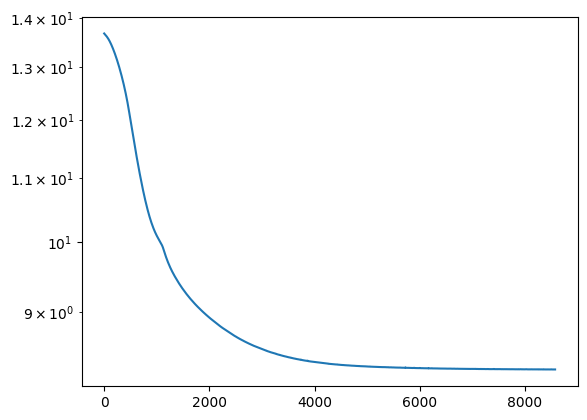

In [6]:
plt.plot(hist.history['loss'])
plt.yscale('log')

In [7]:
test_ds = create_dataset(cube, psf, rot_angles, table, window_size=window_size, batch_size=2000, repeat=1)

In [8]:
pred, flux = model.predict(test_ds)

TypeError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/src/model.py", line 106, in predict_step  *
        output_pred = tf.dynamic_partition(y_pred, idx, tf.shape(unique_ids)[0])

    TypeError: Expected int for argument 'num_partitions' not <tf.Tensor 'strided_slice:0' shape=() dtype=int32>.


In [17]:
y_true = tf.concat([y['ids'] for x, y in test_ds], axis=0)

In [37]:
import tensorflow as tf

unique_ids, idx = tf.unique(y_true)  # Get unique values and indices

output_pred = tf.dynamic_partition(pred, idx, tf.shape(unique_ids)[0])
fluxes = tf.reduce_max(flux, axis=[1,2,3])
output_flux = tf.dynamic_partition(fluxes, idx, tf.shape(unique_ids)[0])

<tf.Tensor: shape=(80,), dtype=float32, numpy=
array([26.544247 , 35.094296 , 29.837261 , 40.041344 , 37.26242  ,
       26.869267 , 32.27415  , 30.584904 , 31.248789 , 35.05363  ,
       17.315945 , 22.183073 , 12.831042 , 15.953278 , 23.503338 ,
       18.656149 , 25.388601 , 10.7860775, 16.539377 , 19.870642 ,
       24.54814  , 22.699947 , 29.688856 , 27.134535 , 26.054583 ,
       25.912857 , 25.941656 , 23.048428 , 19.822367 , 15.755343 ,
       15.537338 , 15.900539 , 18.78738  , 30.52119  , 30.982637 ,
       31.752499 , 44.81496  , 37.122673 , 38.161774 , 35.56899  ,
       52.945503 , 41.73394  , 34.342518 , 31.270664 , 22.068012 ,
       35.39899  , 16.384602 , 16.244192 , 24.278711 , 20.133654 ,
       21.203217 , 26.262787 , 29.143763 , 21.957575 , 28.430601 ,
       32.22733  , 17.207207 , 18.342894 , 17.541069 , 26.770866 ,
       19.479897 , 19.42525  , 19.909412 , 10.947843 , 12.779675 ,
       22.686543 , 30.230461 , 19.78493  , 18.540438 , 19.880583 ,
       20.60504

In [32]:
flux_list = tf.reduce_max(flux, axis=[1,2,3])

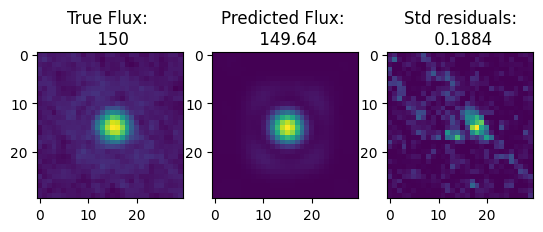

In [36]:
fig, axes = plt.subplots(1, 3)

for x, y in test_ds:
    n = 1

    win_0 = x['windows'][n]
    win_1 = pred[n]
    
    axes[0].imshow(win_0)
    axes[0].set_title('True Flux: \n 150')
    
    axes[1].imshow(win_1)
    axes[1].set_title('Predicted Flux: \n {:.2f}'.format(flux_list[n]))
    
    residuals = tf.math.subtract(win_0, win_1)
    res_square = tf.pow(residuals, 2)
    axes[2].set_title('Std residuals:\n {:.4f}'.format(tf.math.reduce_std(res_square)))
    axes[2].imshow(res_square)
    
    break
    
plt.show()